# Wstęp
Zadanie 12 jest trzecią częścią do zajęć laboratoryjnych poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem prac będzie sieć rekurencyjna do predykcji kursu kryptowaluty Bitcoin (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.   EmoTweet - model sieci rekurencyjnej do analizy emocji (10 pkt., laboratorium 10)
2. Agregacja informacji emotywnej i przygotowanie MultiBTC - multimodalnego model sieci rekurencyjnej do predykcji kursu BTC (10 pkt., laboratorium 11)
3. Ewaluacja modelu MultiBTC (10 pkt., laboratorium 12)

Łącznie można otrzymać 30 punktów.

# Cel ćwiczenia

Celem trzeciego etapu prac jest ewaluacja modelu MultiBTC sieci rekurencyjnej LSTM do przewidywania kolejnego elementu sekwencji pod warunkiem wcześniejszych obserwacji. 

# Warunki zaliczenia

Do zaliczenia trzeciego etapu należy wytrenować modelu oraz wykonać ewaluację predykcji dla scenariusza godzinnego oraz dziennego, z uwzględnieniem wpływu:
 * wybranych hiperparametrów 
 * dodatkowych kroków wstępnego przetwarzania danych
 * wymiarów afektywnych


# Realizacja zadania

Szczegółowa realizacja zadania powinna uwzględniać następujące elementy ewaluacji:

### Hiperparametry (4 pkt.)

W zadaniu tym istnieje szereg ustawień hiperparametrów, które mogą mieć istotny wpływ na jakość predykcji. Należy wybrać jeden z nich i zbadać jego wpływ dla 3 wybranych wartości. 

1. Długość sekwencji w modelu LSTM.
2. Liczba jednostek w warstwie ukrytej. 
3. Optymalizator i jego parametry (np. `learning rate`).
4. Użycie dodatkowej warstwy Dropout (parametr: `probability`) przed warstwą z wynikiem predykcji.

### Przetwarzanie wstępne (3 pkt.)

Jednocześnie istotny wpływ mogą mieć dodatkowe elementy przetwarzania wstępnego danych. Należy wybrać jeden z nich i porównać z wariantem bez przetwarzania:
1. Normalizacja wartości (sprowadzenie konkretnych kwot do wartości z zakresu 0-1).
2. Zamiana wartości liczbowej na procentową zmianę względem poprzedniego kursu.

### Wymiary afektywne  (3 pkt.)

Ostatnim aspektem jest zbadanie wpływu wymiarów afektywnych. Dla najlepszej otrzymanej konfiguracji należy porównać wyniki z modelem, który wykorzystuje wyłącznie dane z giełdy.

### Ogólne uwagi końcowe

Wszystkie wyniki proszę podać z wykorzystaniem 2 miar jakości predykcji:
1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2-score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Przy każdej procedurze uczenia należy wykorzystywać zbiór walidacyjny w taki sposób, by po każdej epoce uczenia sprawdzać jakość predykcji na tym zbiorze. Należy zapamiętać ten model, którego jakość była najlepsza na zbiorze walidacyjnym i na tym modelu dopiero robić ostateczną ewaluację z wykorzystaniem zbioru testowego. Proszę obserwować proces uczenia. Spadek jakości na zbiorze walidacyjnym w dalszych epokach uczenia (po wcześniejszym wzrastaniu w poprzednich epokach) może oznaczać, że model przeuczył się na zbiorze uczącym i można przerwać trenowanie. Często definiuje się w tym celu dodatkowy parametr tzw. **cierpliwości** (ang. patience), który określa, przez ile epok możemy kontynuować uczenie bez otrzymania wyniki lepszego niż dotychczasowy najlepszy.


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

df_1h = pd.read_csv('df_1h.csv')
df_24h = pd.read_csv('df_24h.csv')

device = 'cuda'

# Mod model

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length, -1] 
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def fit(model, criterion, optimizer, num_epochs, train_loader, val_loader, patience = 20):
  train_losses = []
  val_losses = []
  train_r2 = []
  val_r2 = []
  best_loss = np.inf
  counter = 0
  for epoch in tqdm(range(num_epochs)):
      true_values = []
      train_predictions = []
      val_predictions = []


      model.train()
      train_loss = 0.0
      for inputs, targets in train_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets.unsqueeze(1))
          loss.backward()
          optimizer.step()
          train_predictions.extend(outputs.cpu().detach().numpy())
          true_values.extend(targets.cpu().detach().numpy())
          
          train_loss += loss.item()

      train_r2.append(r2_score(true_values, train_predictions))

      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, targets.unsqueeze(1))

              val_predictions.extend(outputs.cpu().detach().numpy())
              true_values.extend(targets.cpu().detach().numpy())

              val_loss += loss.item()
          early_loss = val_loss/len(val_loader)
          val_r2.append(r2_score(true_values[len(train_predictions):], val_predictions))
      train_losses.append(train_loss/len(train_loader)) 
      val_losses.append(val_loss/len(val_loader))
      if early_loss < best_loss:
        best_loss = early_loss
        counter = 0
      else:
        counter += 1
        if counter > patience:
          break


  n = len(train_losses)
  xs = np.arange(1, 1+n)

  return best_loss, xs, train_losses, val_losses, train_r2, val_r2

def MultiBTC(seq_length = 10, target_name = 'close', df = df_24h, num_epochs = 10, hidden_dim = 64, learning_rate = .001, scaler = MinMaxScaler()):
  df_dates =df.copy()
  df = df.copy()
  df.drop(columns = 'date', inplace=True)
  
  cols = list(df.columns)
  cols.remove(target_name)
  df = df[cols + [target_name]]
  if scaler is not None:
    scaled_df = scaler.fit_transform(df)
  else:
    scaled_df = df.to_numpy()
  sequences, targets = create_sequences(scaled_df, seq_length)     

  train_size = int(len(sequences) * 0.8)
  val_size = int(len(sequences) * 0.1)


  train_sequences = sequences[:train_size]
  train_targets = targets[:train_size]
  val_sequences = sequences[train_size:train_size + val_size]
  val_targets = targets[train_size:train_size + val_size]
  test_sequences = sequences[train_size + val_size:]
  test_targets = targets[train_size + val_size:]


  train_dataset = TimeSeriesDataset(train_sequences, train_targets)
  val_dataset = TimeSeriesDataset(val_sequences, val_targets)
  test_dataset = TimeSeriesDataset(test_sequences, test_targets)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  input_dim = train_sequences.shape[2]
  num_layers = 2
  output_dim = 1

  model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model,  *fit(model, criterion, optimizer, num_epochs, train_loader, val_loader), test_loader, scaler, df, df_dates

def plot_results(model, best_loss, xs, train_losses, val_losses, train_r2, val_r2, test_loader, scaler, df, df_dates, printit=True):
  if printit:

    fig, (ax1,ax2) = plt.subplots(1,2,figsize = (25,10))

    ax1.plot(xs, train_losses,label = 'train loss')
    ax1.plot(xs, val_losses,label = 'val loss')
    ax1.set_title("MSE Error for epoch")
    ax1.legend()

    ax2.plot(xs, train_r2,label = 'train r2')
    ax2.plot(xs, val_r2, label = 'val r2')
    ax2.set_title("R2 Error for epoch")
    ax2.legend()  


  model.eval()
  predictions = []
  true_values = []

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          predictions.append(outputs.cpu().numpy())
          true_values.append(targets.cpu().numpy())

  predictions = np.concatenate(predictions)
  true_values = np.concatenate(true_values)
  if scaler is not None:
    predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df.shape[1]-1)), predictions], axis=1))[:, -1]
    true_values = scaler.inverse_transform(np.concatenate([np.zeros((true_values.shape[0], df.shape[1]-1)), true_values.reshape(-1, 1)], axis=1))[:, -1]
  else:
    predictions = np.concatenate([np.zeros((predictions.shape[0], df.shape[1]-1)), predictions], axis=1)[:, -1]
    true_values = np.concatenate([np.zeros((true_values.shape[0], df.shape[1]-1)), true_values.reshape(-1, 1)], axis=1)[:, -1]
  print(f"Best loss: {best_loss}")
  dates = df_dates[len(df_dates) - len(true_values): ]['date']
  return pd.DataFrame({'date': dates, 'True BTC': true_values, 'Predicted BTC': predictions})

def make_model(btc_df, day_model = False, min_idx = None, max_idx = None):
  if day_model:
    btc_df['date'] = pd.to_datetime(btc_df['date'])
    real_df = btc_df[btc_df['date'].dt.time == pd.to_datetime('23:00:00').time()][['date','True BTC']]
    pred_df = btc_df.groupby('date').mean().reset_index()[['date', 'Predicted BTC']]
    btc_df = real_df.merge(pred_df, how = 'left', on = 'date')
  df = btc_df.copy()
  predictions = df['Predicted BTC']
  true_values = df['True BTC']
  n= len(predictions)
  xs = np.arange(n)
  fig, ax = plt.subplots()
  ax.plot(xs[min_idx:max_idx], true_values[min_idx:max_idx], label = 'real')
  ax.plot(xs[min_idx:max_idx], predictions[min_idx:max_idx], label = 'predictions')
  ax.legend()
  print(f'RMSE: {np.sqrt(mean_squared_error(true_values, predictions))}')
  display(df)

# Zad 1

In [9]:
params = {"seq_length": [5,10,15],"hidden_dim": [8,16,32,64], "learning_rate": [0.001, 0.01, 0.1]}

## sequence

In [10]:
import seaborn as sns
N = 10

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


<Axes: >

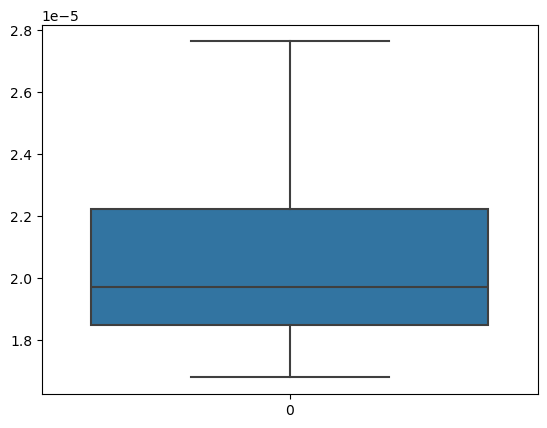

In [11]:
sns.boxplot([MultiBTC(df = df_1h, seq_length=5)[1] for _ in range(N)])

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

Best loss: 2.132979475253237e-05
RMSE: 109.65154232069209


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8896.271643
19008,2020-03-03 01:00:00,8828.270134,8876.751381
19009,2020-03-03 02:00:00,8879.760086,8845.056841
19010,2020-03-03 03:00:00,8880.010186,8837.866594
19011,2020-03-03 04:00:00,8842.279863,8837.945507
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9402.028978
21115,2020-05-29 20:00:00,9421.340059,9400.781405
21116,2020-05-29 21:00:00,9394.860025,9394.982778
21117,2020-05-29 22:00:00,9427.440141,9385.990898


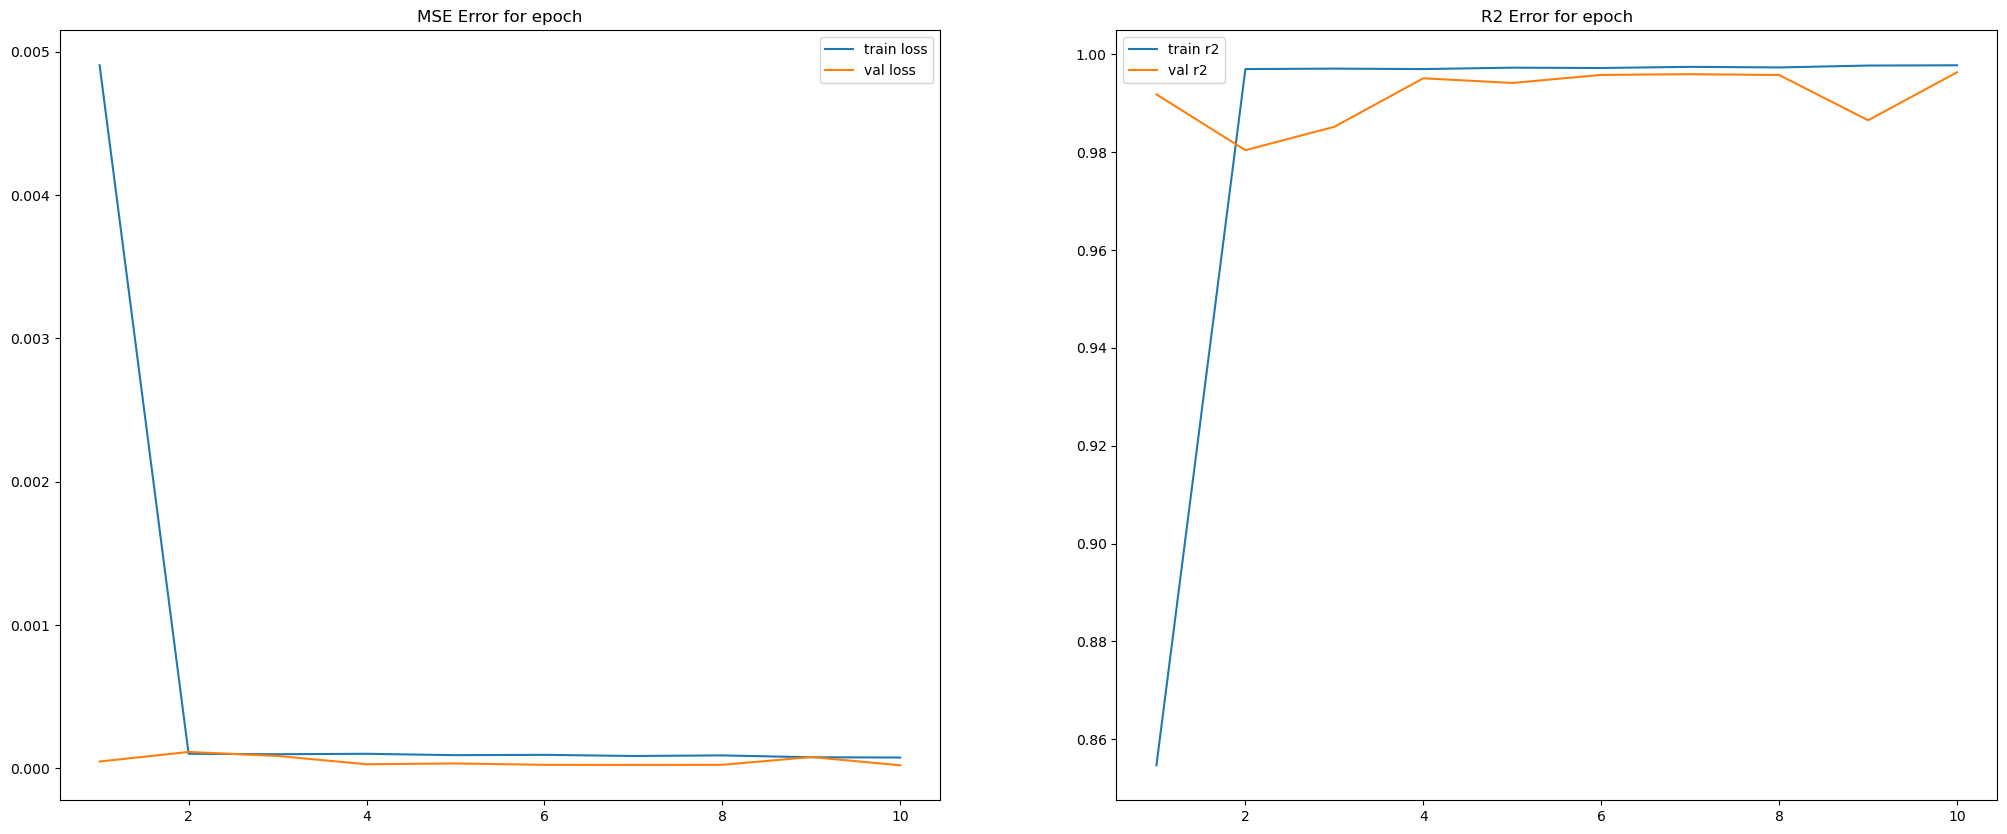

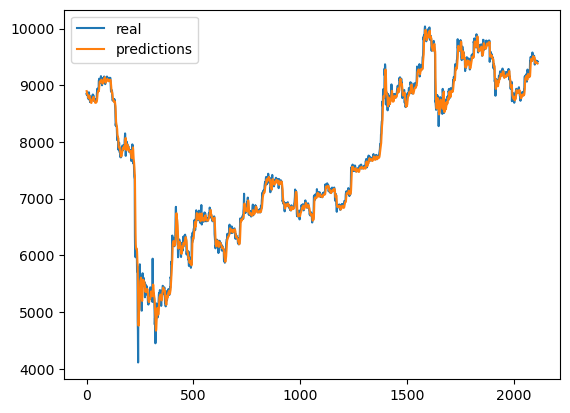

In [12]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=5))
make_model(btc_df)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


<Axes: >

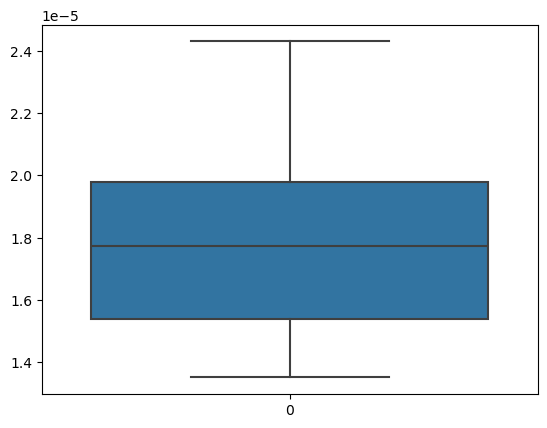

In [13]:
sns.boxplot([MultiBTC(df = df_1h, seq_length=10)[1] for _ in range(N)])

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]

Best loss: 1.528807514587656e-05
RMSE: 97.54968946901542


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8906.658483
19008,2020-03-03 01:00:00,8828.270134,8866.190431
19009,2020-03-03 02:00:00,8879.760086,8831.751899
19010,2020-03-03 03:00:00,8880.010186,8832.109720
19011,2020-03-03 04:00:00,8842.279863,8846.413389
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9401.278681
21115,2020-05-29 20:00:00,9421.340059,9392.477194
21116,2020-05-29 21:00:00,9394.860025,9384.970043
21117,2020-05-29 22:00:00,9427.440141,9378.378113


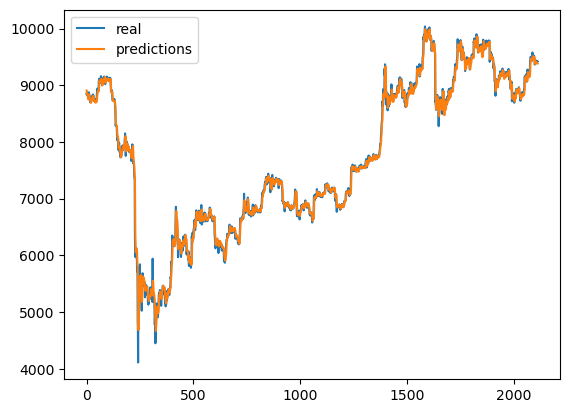

In [14]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=10), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


<Axes: >

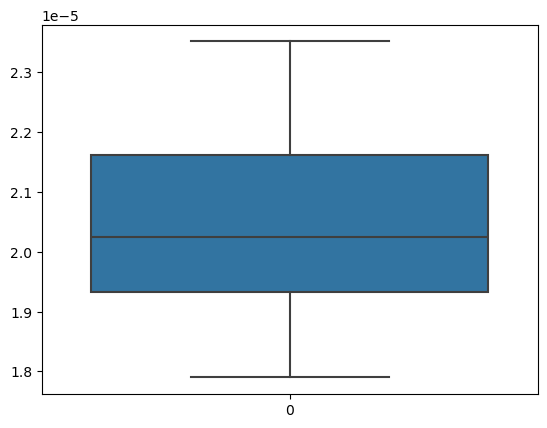

In [15]:
sns.boxplot([MultiBTC(df = df_1h, seq_length=3)[1] for _ in range(N)])

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

Best loss: 2.0124412757964322e-05
RMSE: 124.26405331977158


,date,True BTC,Predicted BTC
19006,2020-03-02 23:00:00,8917.340098,8846.033439
19007,2020-03-03 00:00:00,8848.379945,8861.848559
19008,2020-03-03 01:00:00,8828.270134,8832.799476
19009,2020-03-03 02:00:00,8879.760086,8791.987798
19010,2020-03-03 03:00:00,8880.010186,8779.195162
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9348.671424
21115,2020-05-29 20:00:00,9421.340059,9347.240556
21116,2020-05-29 21:00:00,9394.860025,9336.881690
21117,2020-05-29 22:00:00,9427.440141,9324.427669


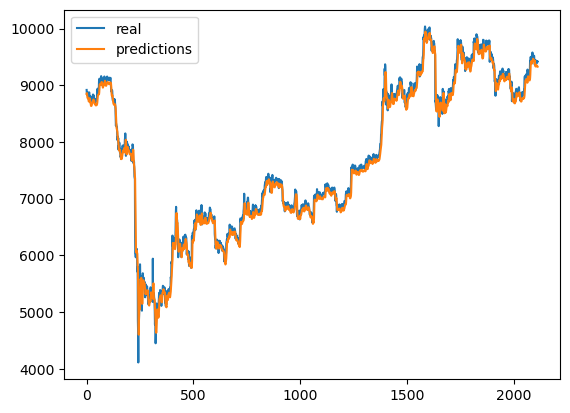

In [16]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=3), printit=False)
make_model(btc_df)

## hidden

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


<Axes: >

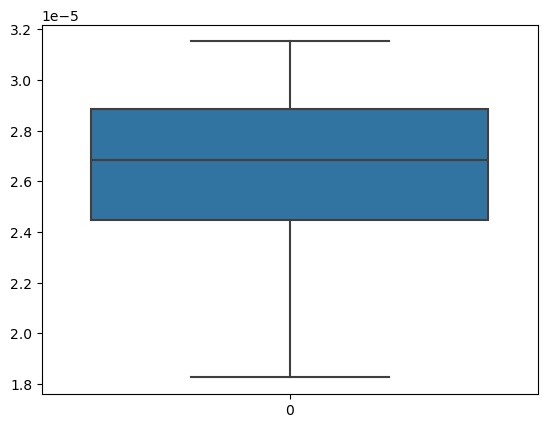

In [17]:
sns.boxplot([MultiBTC(df = df_1h, hidden_dim=8)[1] for _ in range(N)])

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

Best loss: 2.3963644132367556e-05
RMSE: 120.50142784364422


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8951.451289
19008,2020-03-03 01:00:00,8828.270134,8943.275676
19009,2020-03-03 02:00:00,8879.760086,8917.819003
19010,2020-03-03 03:00:00,8880.010186,8901.848145
19011,2020-03-03 04:00:00,8842.279863,8882.948329
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9453.006207
21115,2020-05-29 20:00:00,9421.340059,9452.265512
21116,2020-05-29 21:00:00,9394.860025,9443.831450
21117,2020-05-29 22:00:00,9427.440141,9430.925664


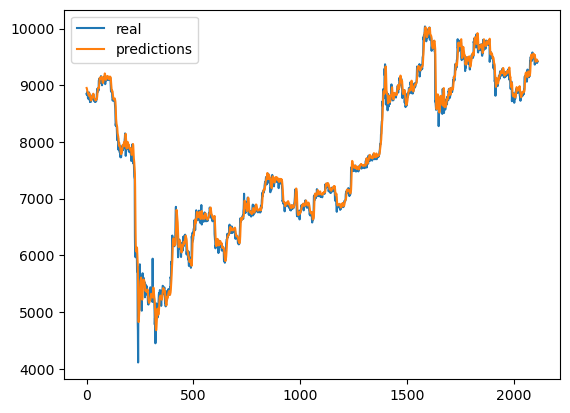

In [18]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=8), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


<Axes: >

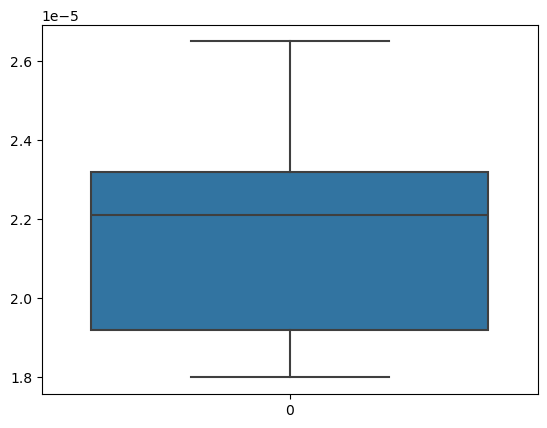

In [19]:
sns.boxplot([MultiBTC(df = df_1h, hidden_dim=16)[1] for _ in range(N)])

100%|██████████| 10/10 [00:13<00:00,  1.35s/it]

Best loss: 2.3712506135504526e-05
RMSE: 110.16311115056497


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8894.768543
19008,2020-03-03 01:00:00,8828.270134,8876.490008
19009,2020-03-03 02:00:00,8879.760086,8846.574137
19010,2020-03-03 03:00:00,8880.010186,8833.551026
19011,2020-03-03 04:00:00,8842.279863,8823.975025
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9392.692220
21115,2020-05-29 20:00:00,9421.340059,9389.604184
21116,2020-05-29 21:00:00,9394.860025,9386.091940
21117,2020-05-29 22:00:00,9427.440141,9377.706311


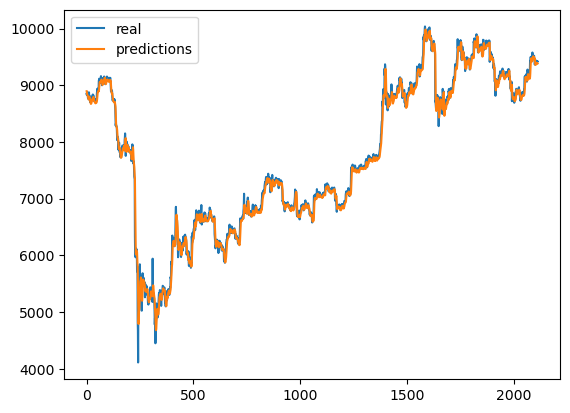

In [20]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=16), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


<Axes: >

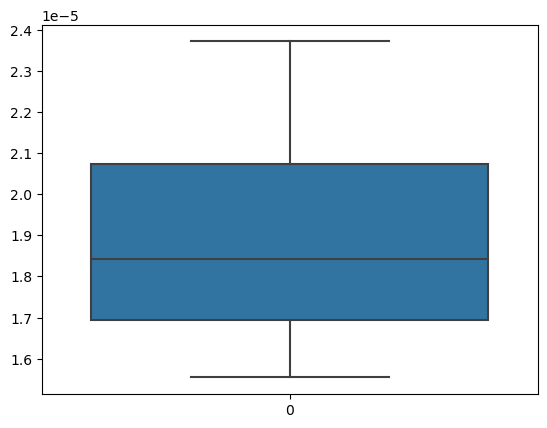

In [21]:
sns.boxplot([MultiBTC(df = df_1h, hidden_dim=32)[1] for _ in range(N)])

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

Best loss: 1.879996208723848e-05
RMSE: 111.34288067967915


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8893.204066
19008,2020-03-03 01:00:00,8828.270134,8869.601216
19009,2020-03-03 02:00:00,8879.760086,8835.815697
19010,2020-03-03 03:00:00,8880.010186,8829.187025
19011,2020-03-03 04:00:00,8842.279863,8827.577455
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9395.318888
21115,2020-05-29 20:00:00,9421.340059,9390.578277
21116,2020-05-29 21:00:00,9394.860025,9382.898270
21117,2020-05-29 22:00:00,9427.440141,9373.502223


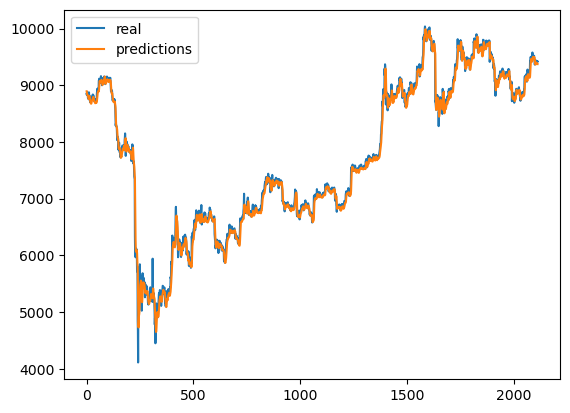

In [22]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=32), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


<Axes: >

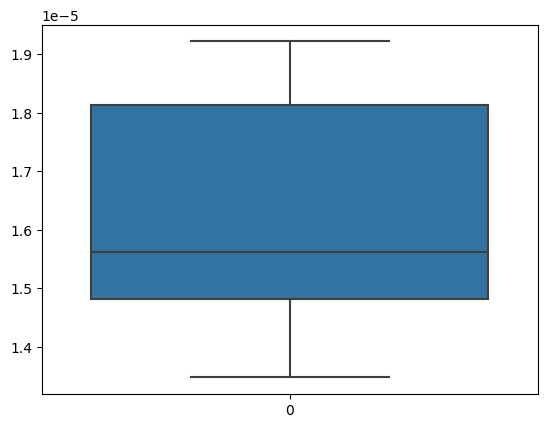

In [23]:
sns.boxplot([MultiBTC(df = df_1h, hidden_dim=64)[1] for _ in range(N)])

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]

Best loss: 1.3233732364493665e-05
RMSE: 91.79038710369109


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8901.114966
19008,2020-03-03 01:00:00,8828.270134,8858.537981
19009,2020-03-03 02:00:00,8879.760086,8820.278233
19010,2020-03-03 03:00:00,8880.010186,8860.950457
19011,2020-03-03 04:00:00,8842.279863,8867.887264
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9400.722951
21115,2020-05-29 20:00:00,9421.340059,9392.099331
21116,2020-05-29 21:00:00,9394.860025,9390.550720
21117,2020-05-29 22:00:00,9427.440141,9381.480345


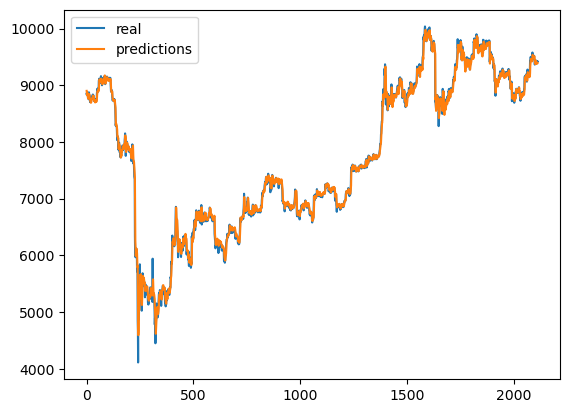

In [24]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=64), printit=False)
make_model(btc_df)

## learning rate

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


<Axes: >

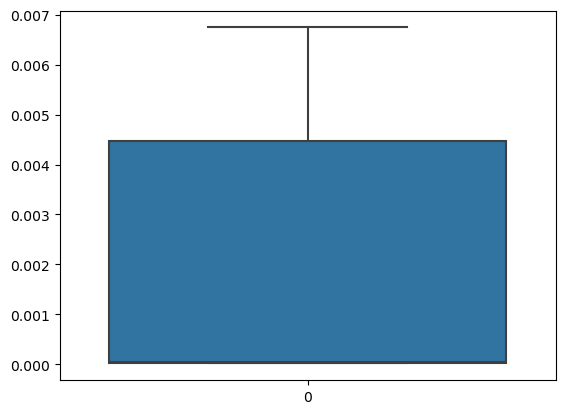

In [25]:
sns.boxplot([MultiBTC(df = df_1h, learning_rate=.1)[1] for _ in range(N)])

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]

Best loss: 5.431059340673638e-05
RMSE: 203.53164788016832


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,9082.165899
19008,2020-03-03 01:00:00,8828.270134,9061.072392
19009,2020-03-03 02:00:00,8879.760086,8990.421669
19010,2020-03-03 03:00:00,8880.010186,9116.052460
19011,2020-03-03 04:00:00,8842.279863,9018.514613
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9658.803599
21115,2020-05-29 20:00:00,9421.340059,9645.891967
21116,2020-05-29 21:00:00,9394.860025,9623.980105
21117,2020-05-29 22:00:00,9427.440141,9593.458819


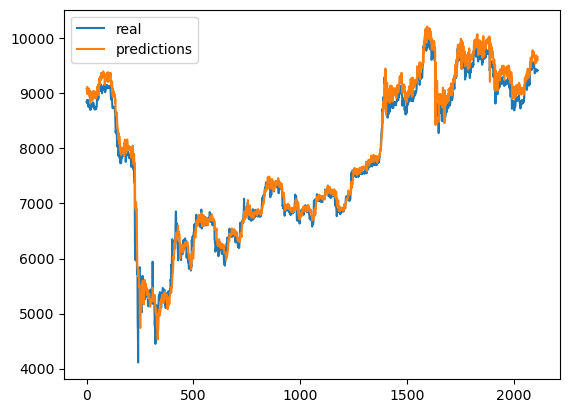

In [26]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.1), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


<Axes: >

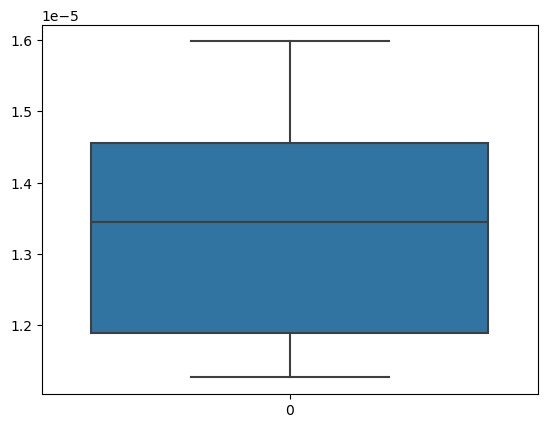

In [27]:
sns.boxplot([MultiBTC(df = df_1h, learning_rate=.01)[1] for _ in range(N)])

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

Best loss: 1.1696391990164667e-05
RMSE: 89.24988886935546


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8903.062316
19008,2020-03-03 01:00:00,8828.270134,8871.678417
19009,2020-03-03 02:00:00,8879.760086,8853.818663
19010,2020-03-03 03:00:00,8880.010186,8866.480195
19011,2020-03-03 04:00:00,8842.279863,8895.213627
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9428.127809
21115,2020-05-29 20:00:00,9421.340059,9418.877062
21116,2020-05-29 21:00:00,9394.860025,9420.696231
21117,2020-05-29 22:00:00,9427.440141,9404.997601


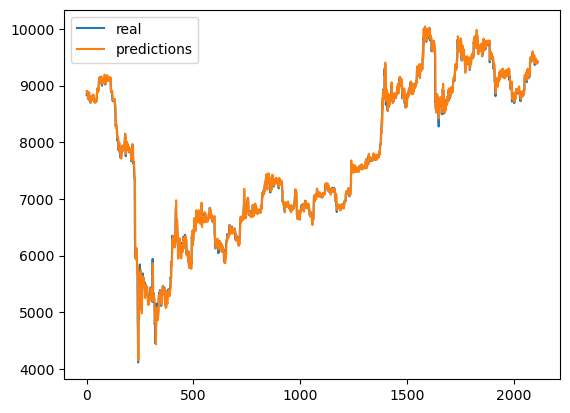

In [28]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.01), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


<Axes: >

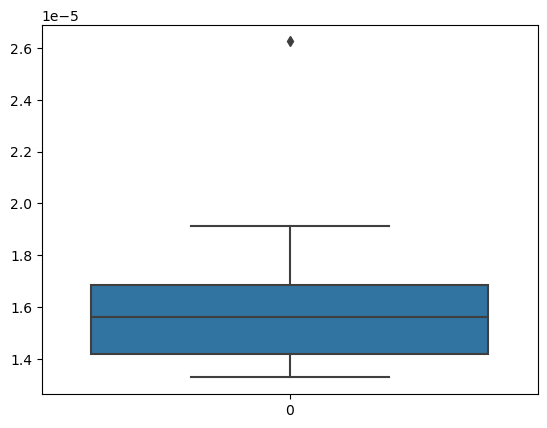

In [29]:
sns.boxplot([MultiBTC(df = df_1h, learning_rate=.001)[1] for _ in range(N)])

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

Best loss: 1.4951474778365192e-05
RMSE: 97.81627383728508


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8879.579714
19008,2020-03-03 01:00:00,8828.270134,8842.265250
19009,2020-03-03 02:00:00,8879.760086,8794.735549
19010,2020-03-03 03:00:00,8880.010186,8818.941309
19011,2020-03-03 04:00:00,8842.279863,8829.012081
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9385.957496
21115,2020-05-29 20:00:00,9421.340059,9370.063881
21116,2020-05-29 21:00:00,9394.860025,9368.428007
21117,2020-05-29 22:00:00,9427.440141,9359.103775


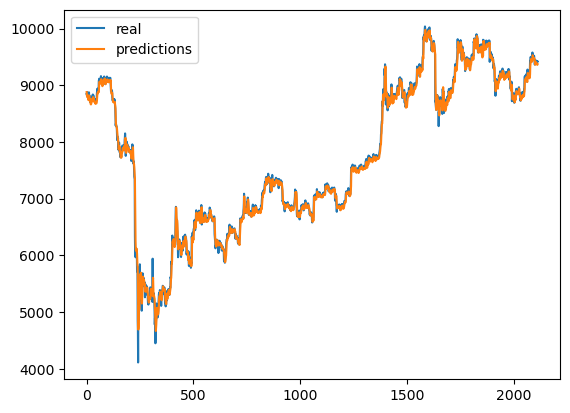

In [30]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.001), printit=False)
make_model(btc_df)

# Zad 2

100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


<Axes: >

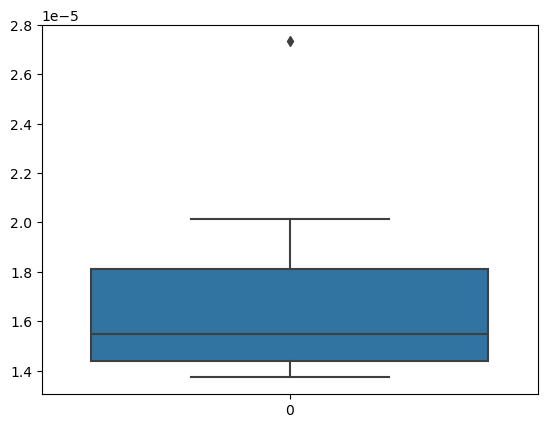

In [32]:
sns.boxplot([MultiBTC(df = df_1h, scaler = MinMaxScaler())[1] for _ in range(N)])

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]

Best loss: 1.2553531639765204e-05
RMSE: 93.03841908978403


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8919.714997
19008,2020-03-03 01:00:00,8828.270134,8875.177718
19009,2020-03-03 02:00:00,8879.760086,8839.474911
19010,2020-03-03 03:00:00,8880.010186,8847.757829
19011,2020-03-03 04:00:00,8842.279863,8865.936574
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9423.726648
21115,2020-05-29 20:00:00,9421.340059,9408.141586
21116,2020-05-29 21:00:00,9394.860025,9404.327469
21117,2020-05-29 22:00:00,9427.440141,9391.545689


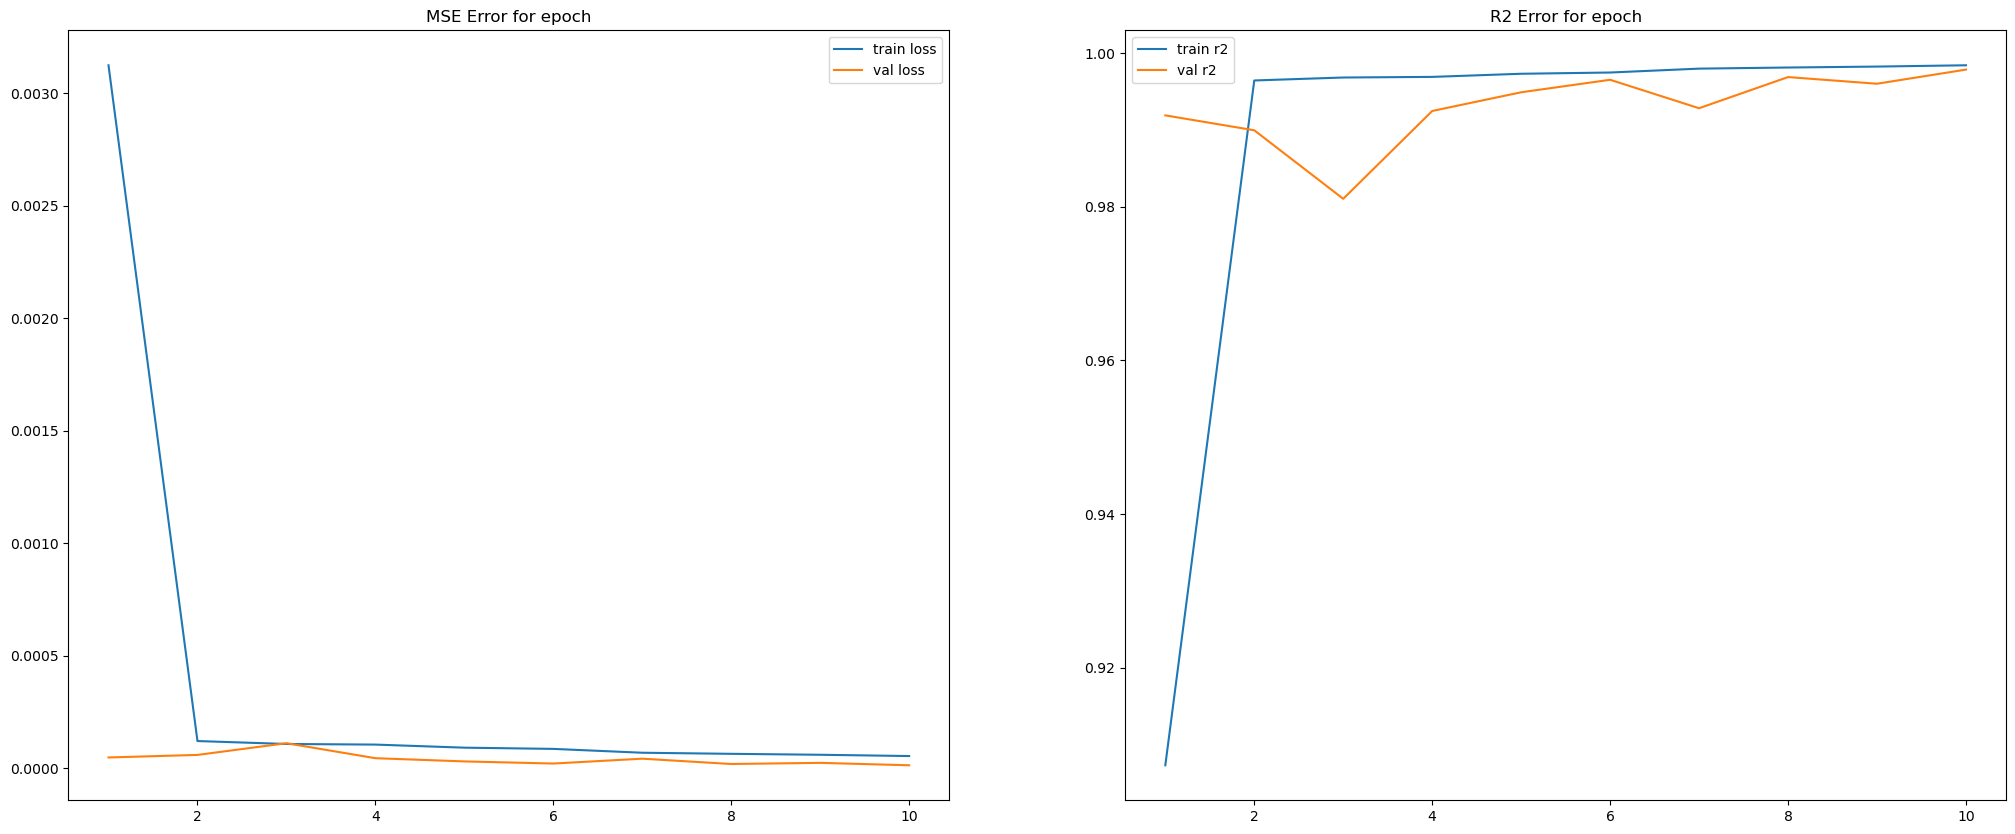

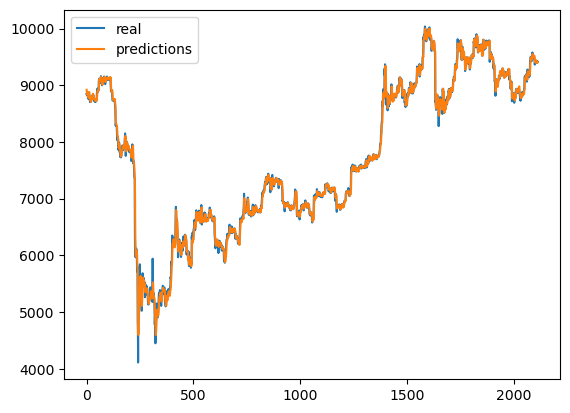

In [33]:
btc_df = plot_results(*MultiBTC(df = df_1h, scaler = MinMaxScaler()), printit=True)
make_model(btc_df)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:14<00:00,  2.55s/it]

Best loss: 26676601.606060605
RMSE: 4542.7470043534295


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379883,3390.286621
19008,2020-03-03 01:00:00,8828.269531,3390.286621
19009,2020-03-03 02:00:00,8879.759766,3390.286621
19010,2020-03-03 03:00:00,8880.009766,3390.286621
19011,2020-03-03 04:00:00,8842.280273,3390.286621
...,...,...,...
21114,2020-05-29 19:00:00,9403.990234,3390.286621
21115,2020-05-29 20:00:00,9421.339844,3390.286621
21116,2020-05-29 21:00:00,9394.860352,3390.286621
21117,2020-05-29 22:00:00,9427.440430,3390.286621


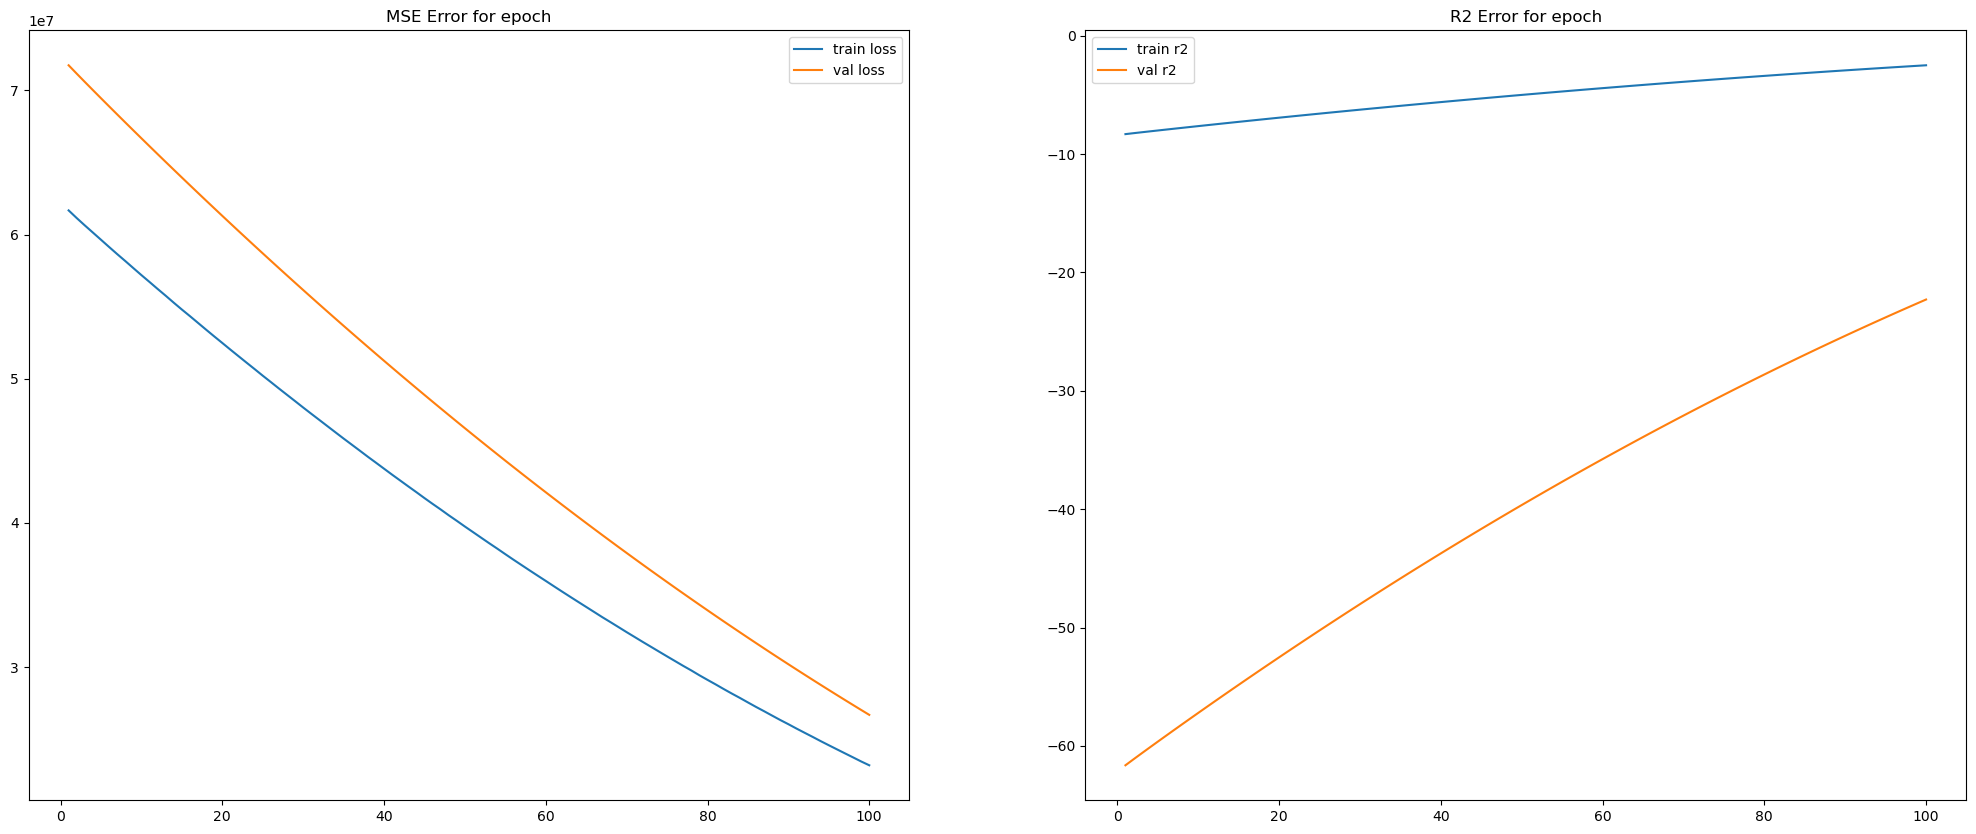

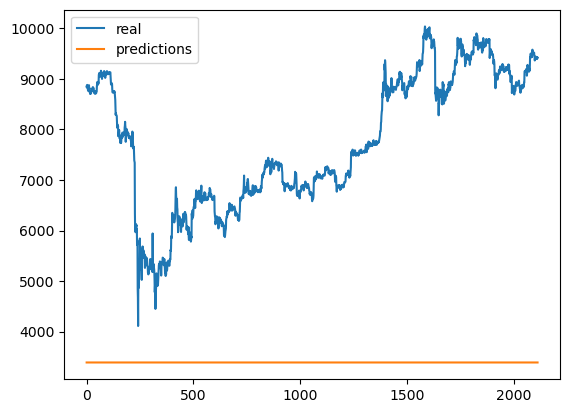

In [34]:
btc_df = plot_results(*MultiBTC(df = df_1h, scaler = None, num_epochs=100), printit=True)
make_model(btc_df)

# Zad 3

In [ ]:
stock_cols = ["date", "open", "high", "low"	,"close", "volume"]

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Best loss: 1.3610337348244215e-05
RMSE: 95.43691948348636


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8934.632850
19008,2020-03-03 01:00:00,8828.270134,8891.766100
19009,2020-03-03 02:00:00,8879.760086,8864.906115
19010,2020-03-03 03:00:00,8880.010186,8868.513556
19011,2020-03-03 04:00:00,8842.279863,8892.402412
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9439.588949
21115,2020-05-29 20:00:00,9421.340059,9431.613750
21116,2020-05-29 21:00:00,9394.860025,9427.421770
21117,2020-05-29 22:00:00,9427.440141,9419.164739


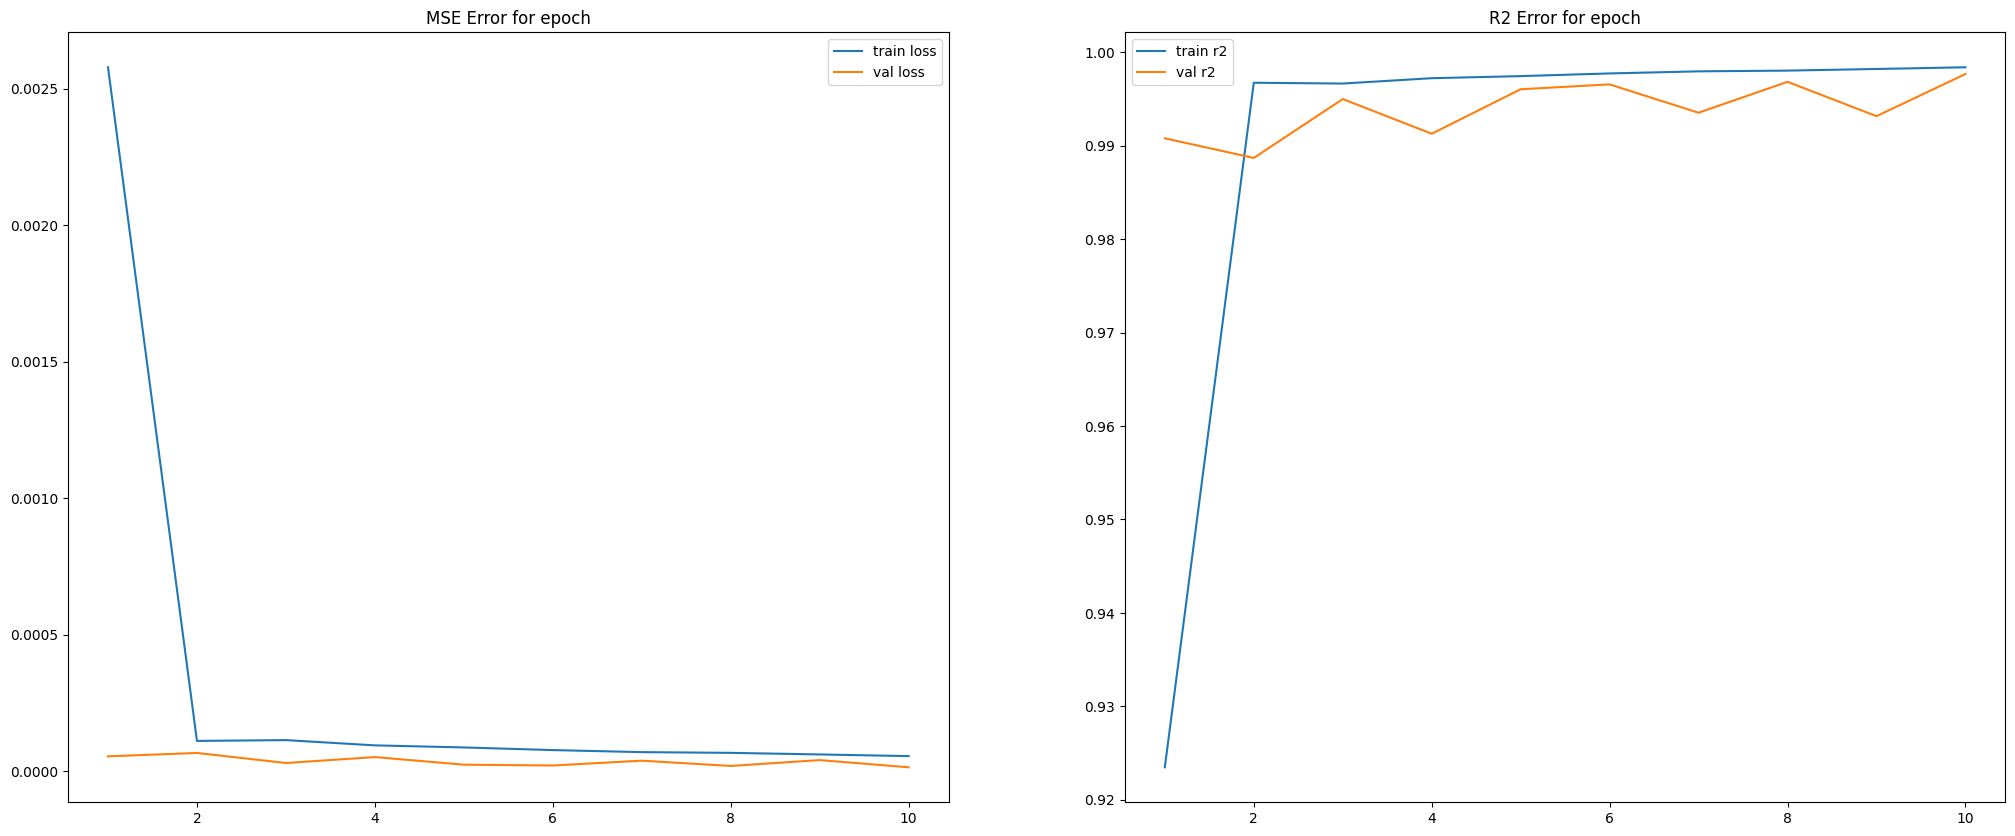

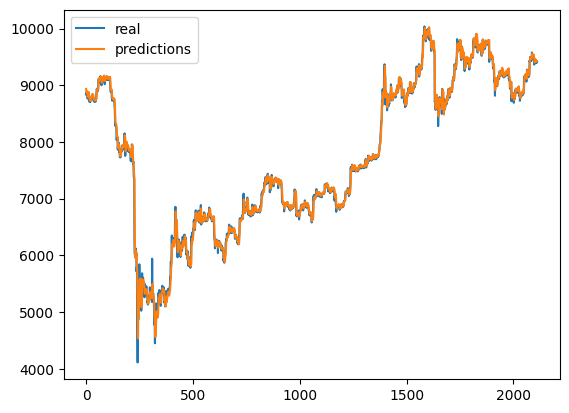

In [ ]:
btc_df = plot_results(*MultiBTC(df = df_1h[stock_cols]), printit=True)
make_model(btc_df)

In [ ]:
import itertools
def all_subsets(lst):
    subsets = []
    for i in range(len(lst) + 1):
        for subset in itertools.combinations(lst, i):
            subsets.append(list(subset))
    return subsets

cols = list(df_1h.columns)
cols.remove('date')
cols.remove('close')
all_cols_subsets = all_subsets(cols)

In [ ]:
dict_to_plot = {}
#model, best_loss, xs, train_losses, val_losses, train_r2, val_r2, test_loader, scaler, df, df_dates 
for cols_subset in all_cols_subsets:
    key = ['date', 'close'] + cols_subset
    results = MultiBTC(df = df_1h[key])
    dict_to_plot[str(key)] = results

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


In [ ]:
key = min(dict_to_plot, key= lambda k: dict_to_plot[k][1])
print(key)

['date', 'close', 'open', 'high', 'low']


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]

Best loss: 1.286759259004832e-05
RMSE: 94.27441874779402


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8912.167346
19008,2020-03-03 01:00:00,8828.270134,8872.726830
19009,2020-03-03 02:00:00,8879.760086,8841.484890
19010,2020-03-03 03:00:00,8880.010186,8845.914861
19011,2020-03-03 04:00:00,8842.279863,8867.797496
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9414.401164
21115,2020-05-29 20:00:00,9421.340059,9405.777961
21116,2020-05-29 21:00:00,9394.860025,9402.724162
21117,2020-05-29 22:00:00,9427.440141,9394.235821


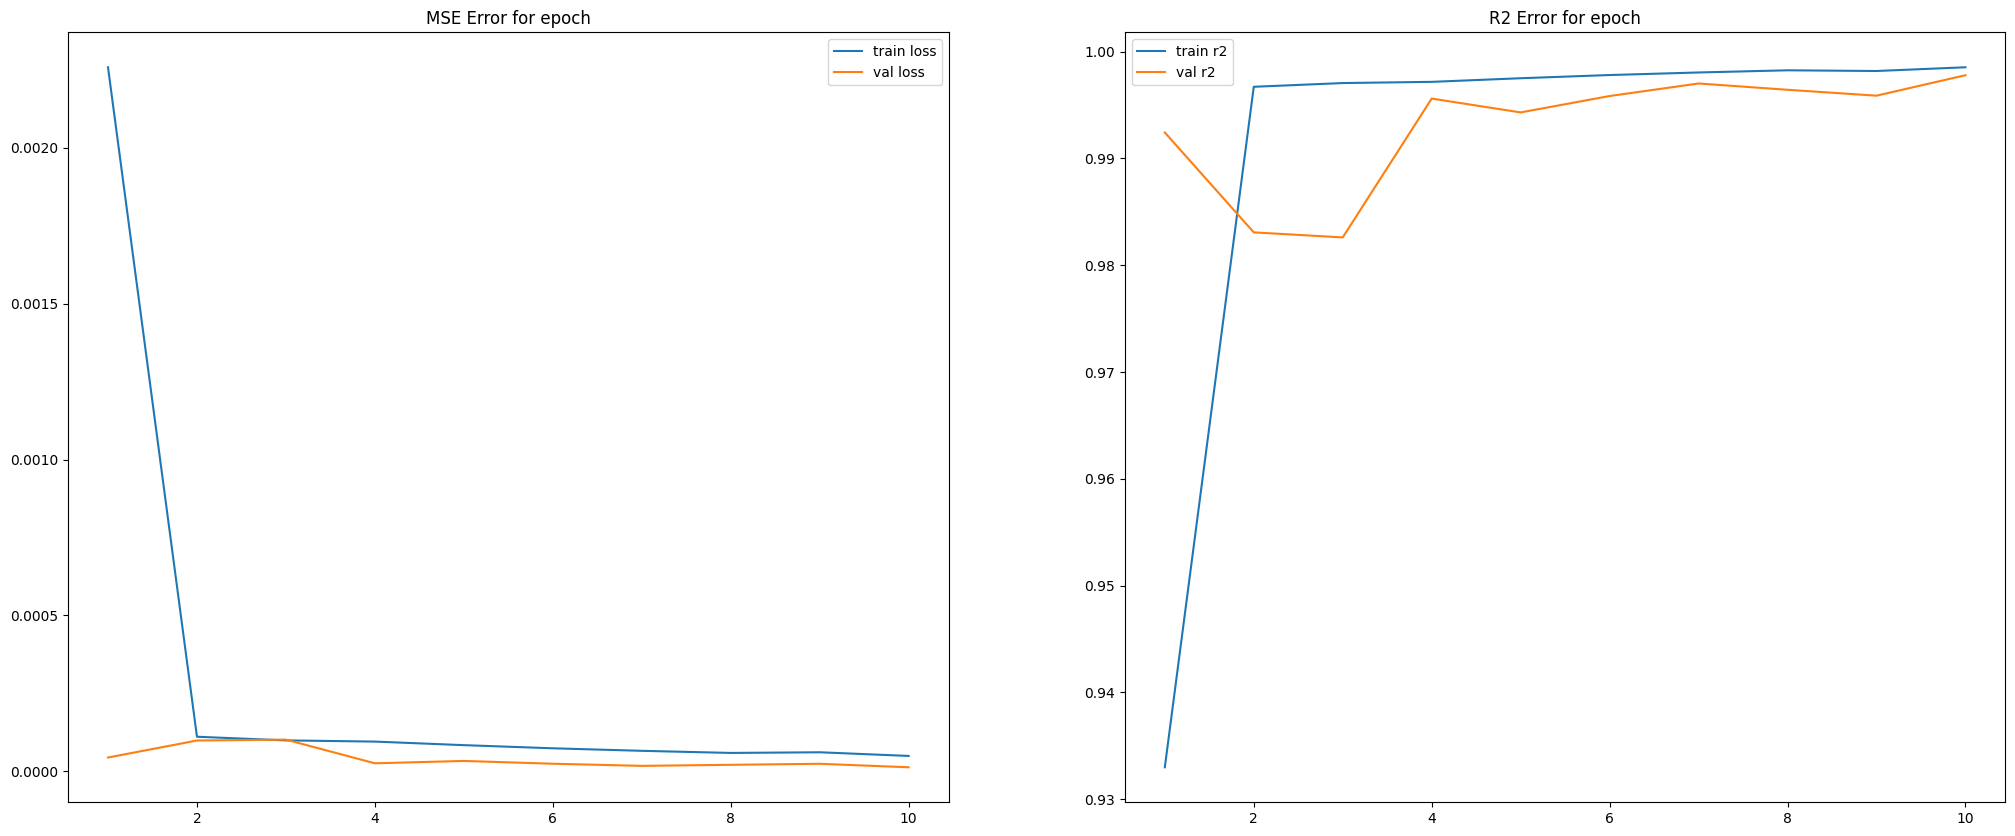

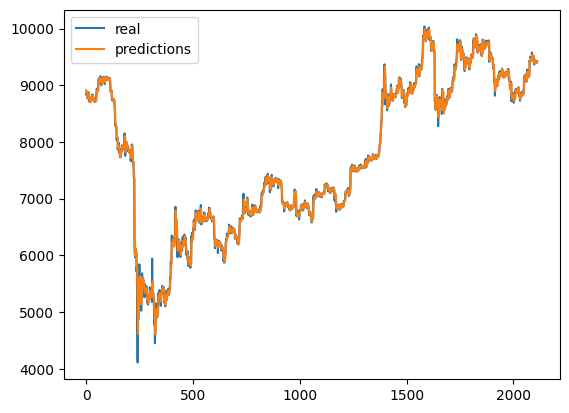

In [ ]:
btc_df = plot_results(*MultiBTC(df = df_1h[['date', 'close', 'open', 'high', 'low']]), printit=True)
make_model(btc_df)

RMSE: 131.5435354553039


,date,True BTC,Predicted BTC
0,2020-03-03 23:00:00,8755.449936,8746.456803
1,2020-03-04 23:00:00,8753.280044,8734.237016
2,2020-03-05 23:00:00,9066.650147,9094.313037
3,2020-03-06 23:00:00,9153.789880,9116.692530
4,2020-03-07 23:00:00,8893.930147,8898.365545
...,...,...,...
83,2020-05-25 23:00:00,8903.560009,8895.759336
84,2020-05-26 23:00:00,8840.909955,8831.071328
85,2020-05-27 23:00:00,9209.999985,9085.568751
86,2020-05-28 23:00:00,9577.379821,9469.979967


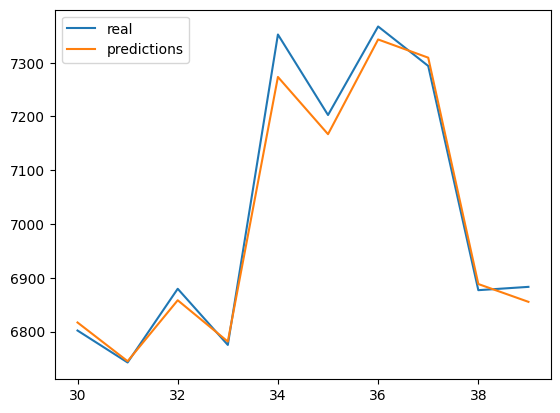

In [ ]:
make_model(btc_df,  min_idx=30, max_idx = 40,day_model=True)